## Tip Prediction Project - Tom

In [2]:
#%pip install seaborn pandas numpy matplotlib scikit-learn holidays

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import OneHotEncoder

### Load Data

In [5]:
# CSV-Dateien: direkt begrenzen´
order_products = pd.read_csv('order_products.csv.zip')
products = pd.read_csv('products.csv.zip')
departments = pd.read_csv('departments.csv.zip')
aisles = pd.read_csv('aisles.csv.zip')
tips = pd.read_csv('tip25_trainingdata.csv.zip')
#tips = tips.dropna(inplace=True) #Drop NaN-Values ERST SPÄTER DA WIR die zugehörigen Orders dann ja auch droppen wollen oder?

Ursprüngliche Begrenzung nicht zielführend, zerstört Zusammenhänge, tip nan drop hier behält trotzdem nan orders

## Extend Orders Dataframe

Hab obvious sachen wie heads die wir bei den Labs shcon hatten rausgenommen, für was erst der calendar erstellt wurde hab ich nicht verstanden

In [6]:
orders = pd.read_parquet('orders.parquet')
# Make sure 'order_date' is datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Add weekday name
orders['weekday'] = orders['order_date'].dt.day_name()

# Add hour 
orders["hour"] = orders["order_date"].dt.hour

#Add week
orders["week-start"] = orders["order_date"].dt.to_period("W").dt.start_time
# Flag weekends: Saturday or Sunday
orders['is_weekend'] = orders['weekday'].isin(['Saturday', 'Sunday']).astype(int)

#Add number of previous orders per user
orders = orders.sort_values(["user_id","order_date"])
orders["nr_previous_orders"] = orders.groupby("user_id").cumcount()

#Add days since last order per user
orders["days_since_last_order"] = orders.groupby("user_id")["order_date"].diff().dt.days
orders["days_since_last_order"] = orders["days_since_last_order"].fillna(0).astype(int) #erste Bestellung mit 0 Tagen

#Add month start/middle/end classification
def month_classification(order_date):
    year = order_date.year
    month = order_date.month
    day = order_date.day
    nr_days_month = calendar.monthrange(year, month)[1]
    first_third = nr_days_month // 3
    middle_third = 2 * nr_days_month // 3
    if day <= first_third:
        return "Start"
    elif day <= middle_third:
        return "Middle"
    else:
        return "End"
    
orders["month-period"] = orders["order_date"].dt.date.apply(month_classification)
orders.head(10)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle


# Analysing order features influence on tipping behaviour

In [7]:
orders_and_tips = pd.merge(orders, tips, on="order_id", how="left")
orders_and_tips = orders_and_tips[orders_and_tips["tip"].notna()] #drop last order per user where tip is NaN
orders_and_tips.head(20)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start,5.0,True
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle,6.0,False
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End,7.0,False
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End,8.0,False
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle,9.0,False


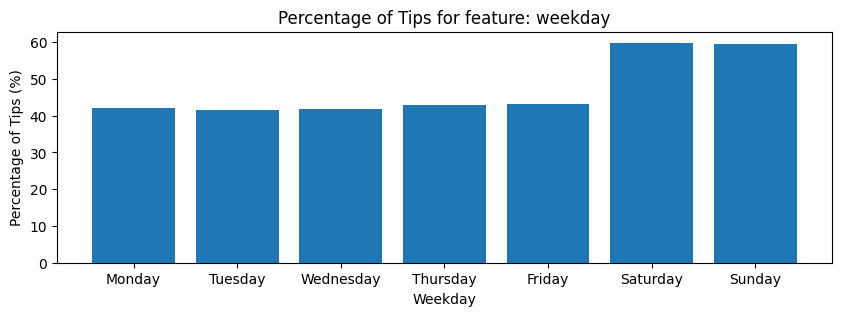

Höchste Tip-Wkeiten
                 tip
weekday             
Saturday   59.832629
Sunday     59.406033
Friday     43.207775
Thursday    42.99998
Monday     42.083245
Wednesday  41.904066
Tuesday    41.441993


In [8]:
### Testing weekday influence
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tip_by_testfeature = orders_and_tips[["weekday","tip"]].groupby("weekday").mean()*100
tip_by_testfeature = tip_by_testfeature.reindex(weekday_order)
plt.figure(figsize=(10, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('Weekday')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: weekday')
plt.show()
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))


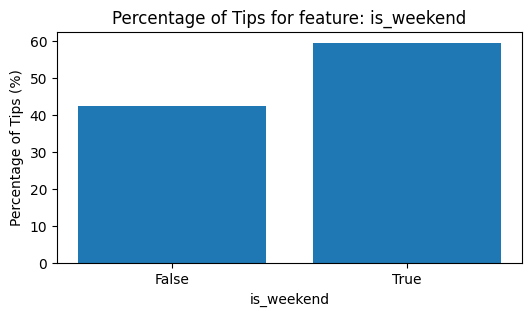

Korrelation:  0.1634585571320016
Höchste Tip-Wkeiten
                  tip
is_weekend           
1           59.609686
0           42.328774


In [9]:
### Testing is_weekend influence
tip_by_testfeature = orders_and_tips[["is_weekend","tip"]].groupby("is_weekend").mean()*100
plt.figure(figsize=(6, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('is_weekend')
plt.ylabel('Percentage of Tips (%)')
plt.xticks([0,1], ['False', 'True'], rotation=0)
plt.title('Percentage of Tips for feature: is_weekend')
plt.show()
corr_matrix = orders_and_tips["is_weekend"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

### --> Wochenende hat einen Einfluss!

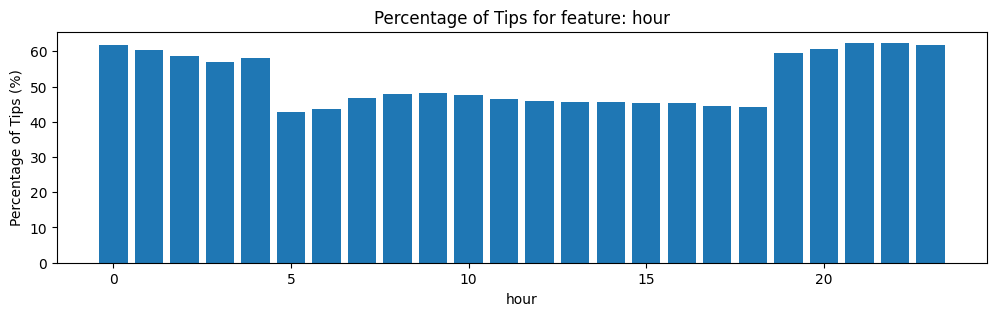

Korrelation:  0.03617046887262722
Höchste Tip-Wkeiten
            tip
hour           
22    62.448434
21    62.304509
23    61.817165
0     61.731813
20    60.537998
1     60.248578
19    59.416679
2     58.789723
4     58.223395
3     56.969697


In [10]:
### Testing hour influence
tip_by_testfeature = orders_and_tips[["hour","tip"]].groupby("hour").mean()*100
plt.figure(figsize=(12, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('hour')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: hour')
plt.show()
corr_matrix = orders_and_tips["hour"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))


### --> Tageszeit der Bestellung hat einen Einfluss

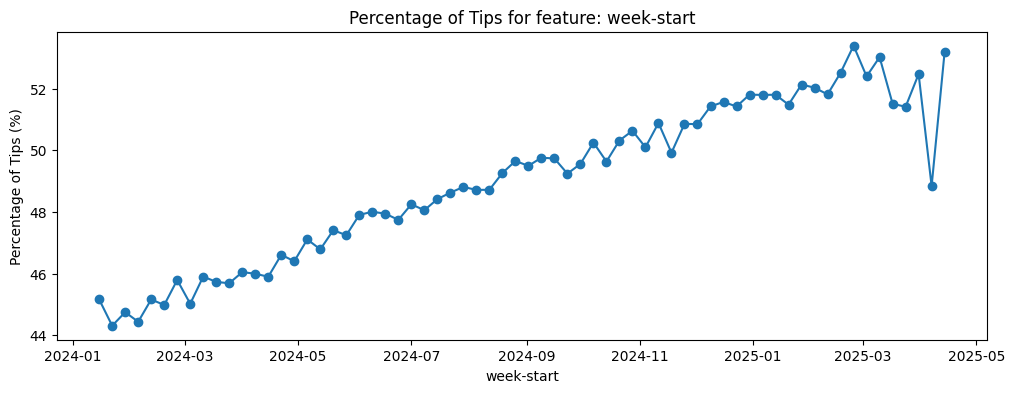

Höchste Tip-Wkeiten
                  tip
week-start           
2025-02-24   53.38822
2025-04-14  53.191489
2025-03-10  53.017985
2025-02-17  52.510858
2025-03-31  52.468619
2025-03-03  52.393928
2025-01-27  52.130682
2025-02-03  52.026821
2025-02-10  51.810748
2024-12-30  51.801655


In [11]:
### Testing week-start influence
tip_by_testfeature = orders_and_tips[["week-start","tip"]].groupby("week-start").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('week-start')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: week-start')
plt.show()
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

### --> Tip Wahrscheinlichkeit nimmt mit der Zeit zu

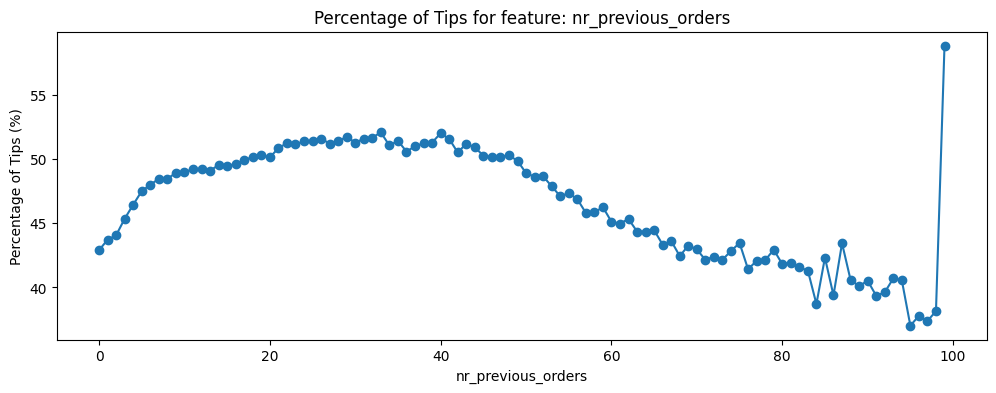

Korrelation:  -0.0021782900618040344
Höchste Tip-Wkeiten
                          tip
nr_previous_orders           
99                  58.823529
33                  52.061307
40                  51.999059
29                   51.73646
32                  51.666059
26                  51.590088
31                  51.580069
41                  51.558558
25                   51.42513
35                  51.408264


In [12]:
### Testing nr_previous_orders influence
tip_by_testfeature = orders_and_tips[["nr_previous_orders","tip"]].groupby("nr_previous_orders").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('nr_previous_orders')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: nr_previous_orders')
plt.show()
corr_matrix = orders_and_tips["nr_previous_orders"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

### --> Tip Wahrscheinlichkeit nimmt bis zu ~20 Bestellungen eines Users zu, dort erreicht sie ein Plateau bis ~40 und sinkt danach wieder.

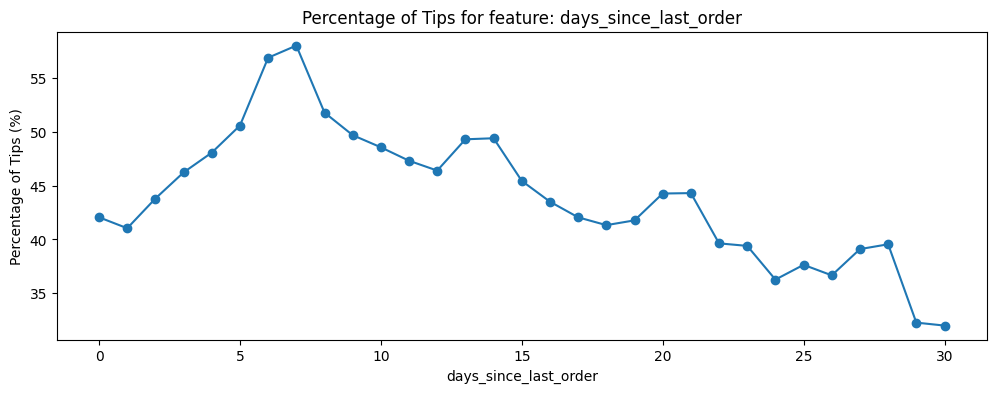

Korrelation:  0.003130783249031305
Höchste Tip-Wkeiten
                             tip
days_since_last_order           
7                      58.005665
6                      56.877375
8                      51.780681
5                      50.578879
9                      49.684993
14                     49.397636
13                      49.29972
10                     48.555957
4                      48.061941
11                     47.307665


In [13]:
### Testing days_since_last_order influence
tip_by_testfeature = orders_and_tips[["days_since_last_order","tip"]].groupby("days_since_last_order").mean()*100
plt.figure(figsize=(12, 4))
plt.plot(tip_by_testfeature.index, tip_by_testfeature["tip"], marker="o")
plt.xlabel('days_since_last_order')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: days_since_last_order')
plt.show()
corr_matrix = orders_and_tips["days_since_last_order"].corr(orders_and_tips["tip"])
print("Korrelation: ", corr_matrix)
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

### --> Die Tip Wahrscheinlichkeit nimmt mit größer werdendem Abstand zur letzten Bestellung ab der 7ten Bestellung ab. Bis dahin steigt sie.

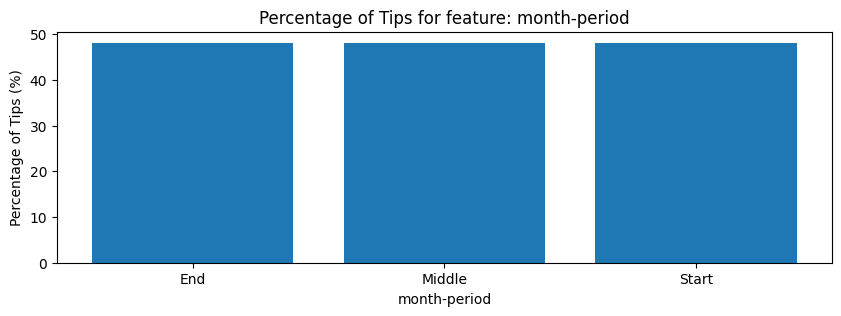

Höchste Tip-Wkeiten
                    tip
month-period           
End           48.165664
Start          48.16009
Middle        48.121088


In [14]:
### Testing month-period influence
tip_by_testfeature = orders_and_tips[["month-period","tip"]].groupby("month-period").mean()*100
plt.figure(figsize=(10, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('month-period')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: month-period')
plt.show()
print("Höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))


### --> Der monatliche Zeitpunkt Beginn/Mitte/Ende des Monats hat keinen Einflus auf die Tip-Wahrscheinlichkeit

# Analysing products influence on tipping behaviour
größe der bestellungen 
regelmäßigkeit der bestellungen
welches produkt am meisten tips hat (department = art des produkts, aisles = genaue kategorie)


In [16]:
order_products = pd.read_csv('order_products.csv.zip')
products = pd.read_csv('products.csv.zip')
departments = pd.read_csv('departments.csv.zip')
aisles = pd.read_csv('aisles.csv.zip')
orders = pd.read_parquet('orders.parquet')


In [17]:
order_products_details = pd.merge(order_products, products, on="product_id", how="left")
order_products_details = order_products_details.drop(columns="product_name")
order_products_details.head()


,order_id,product_id,add_to_cart_order,aisle_id,department_id
0,1,49302,1,120,16
1,1,11109,2,108,16
2,1,10246,3,83,4
3,1,49683,4,83,4
4,1,43633,5,95,15


In [18]:
orders_and_order_products_details = pd.merge(orders, order_products_details, on="order_id", how="left")
orders_and_order_products_details.head()

,order_id,user_id,order_date,product_id,add_to_cart_order,aisle_id,department_id
0,1374495,3,2024-03-31 14:05:18,9387.0,1.0,24.0,4.0
1,1374495,3,2024-03-31 14:05:18,17668.0,2.0,91.0,16.0
2,1374495,3,2024-03-31 14:05:18,15143.0,3.0,24.0,4.0
3,1374495,3,2024-03-31 14:05:18,16797.0,4.0,24.0,4.0
4,1374495,3,2024-03-31 14:05:18,39190.0,5.0,91.0,16.0


In [19]:
orders_details_and_tip = pd.merge(orders_and_order_products_details, tips, on="order_id", how="left")
orders_details_and_tip.head()

,order_id,user_id,order_date,product_id,add_to_cart_order,aisle_id,department_id,Unnamed: 0,tip
0,1374495,3,2024-03-31 14:05:18,9387.0,1.0,24.0,4.0,0.0,True
1,1374495,3,2024-03-31 14:05:18,17668.0,2.0,91.0,16.0,0.0,True
2,1374495,3,2024-03-31 14:05:18,15143.0,3.0,24.0,4.0,0.0,True
3,1374495,3,2024-03-31 14:05:18,16797.0,4.0,24.0,4.0,0.0,True
4,1374495,3,2024-03-31 14:05:18,39190.0,5.0,91.0,16.0,0.0,True


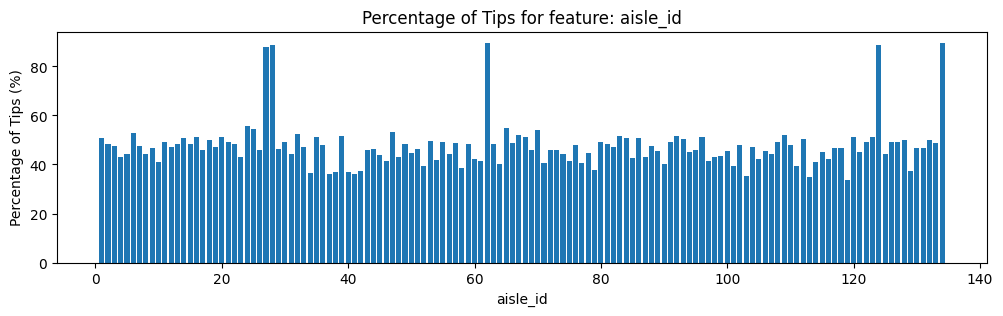

Korrelation:  -0.011921415975361118
10 höchste Tip-Wkeiten
                tip
aisle_id           
62.0      89.683279
134.0     89.441277
28.0      88.634412
124.0     88.630679
27.0       87.85018
24.0      55.715457
65.0       54.93345
25.0      54.343247
70.0      54.240416
47.0        53.0562


In [20]:
### Testing aisle influence
tip_by_testfeature = orders_details_and_tip[["aisle_id","tip"]].groupby("aisle_id").mean()*100
plt.figure(figsize=(12, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('aisle_id')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: aisle_id')
plt.show()
corr_matrix = orders_details_and_tip["aisle_id"].corr(orders_details_and_tip["tip"])
print("Korrelation: ", corr_matrix)
print("10 höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

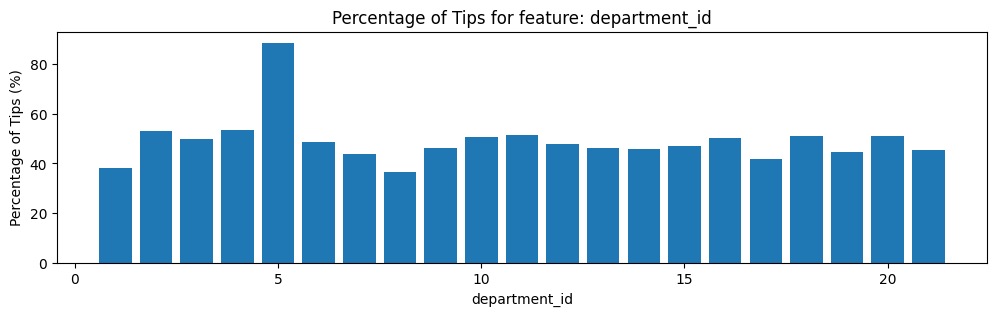

Korrelation:  -0.015029712534102435
10 höchste Tip-Wkeiten
                     tip
department_id           
5.0            88.661639
4.0            53.240985
2.0            52.926518
11.0           51.324899
20.0           51.160257
18.0           51.017835
10.0           50.545943
16.0           50.067001
3.0            49.680503
6.0            48.654744


In [21]:
### Testing department influence
tip_by_testfeature = orders_details_and_tip[["department_id","tip"]].groupby("department_id").mean()*100
plt.figure(figsize=(12, 3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel('department_id')
plt.ylabel('Percentage of Tips (%)')
plt.title('Percentage of Tips for feature: department_id')
plt.show()
corr_matrix = orders_details_and_tip["department_id"].corr(orders_details_and_tip["tip"])
print("Korrelation: ", corr_matrix)
print("10 höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

In [22]:
### Testing product influence
tip_by_testfeature = orders_details_and_tip[["product_id","tip"]].groupby("product_id").mean()*100
# plt.figure(figsize=(12, 3))
# plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
# plt.xlabel('product_id')
# plt.ylabel('Percentage of Tips (%)')
# plt.title('Percentage of Tips for feature: product_id')
# plt.show()
# plot dauert ne gute minute
corr_matrix = orders_details_and_tip["product_id"].corr(orders_details_and_tip["tip"])
print("Korrelation: ", corr_matrix)
print("10 höchste Tip-Wkeiten")
print(tip_by_testfeature.sort_values(by="tip",ascending=False).head(10))

Korrelation:  0.0018724341012811099
10 höchste Tip-Wkeiten
              tip
product_id       
35397.0     100.0
15859.0     100.0
6590.0      100.0
30335.0     100.0
24258.0     100.0
6591.0      100.0
15833.0     100.0
15836.0     100.0
24266.0     100.0
15847.0     100.0


# Trainingsset und Testset

In [23]:
#Make sure it´s sorted
orders_and_tips = orders_and_tips.sort_values(["user_id", "order_date"]) #(letzte NaN Bestellung eines Users wurde schon oben gerdropt)
orders_and_tips.head(20) 

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start,5.0,True
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle,6.0,False
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End,7.0,False
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End,8.0,False
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle,9.0,False


In [24]:
last_order_idx = orders_and_tips.groupby("user_id")["order_date"].idxmax()

test_set = orders_and_tips.loc[last_order_idx]
print(test_set[["order_id","user_id","order_date","tip"]].head(10))

     order_id  user_id          order_date    tip
11    1402502        3 2024-08-11 15:51:44   True
16     157374        5 2024-05-12 18:34:15  False
20     998866        6 2024-02-26 18:12:42   True
33    1789302       13 2024-06-21 13:46:17   True
56     487368       15 2024-10-20 10:46:52  False
63     441977       18 2024-03-01 12:04:27   True
73      86918       19 2024-05-23 16:33:28   True
155   1573122       27 2025-03-16 13:34:07  False
174   1647841       29 2024-08-15 11:04:51  False
195    813240       31 2024-07-20 17:30:00  False


In [25]:
train_set = orders_and_tips.drop(last_order_idx)
print(train_set[["order_id","user_id","order_date","tip"]].head(20))

    order_id  user_id          order_date    tip
0    1374495        3 2024-03-31 14:05:18   True
1     444309        3 2024-04-09 19:45:51  False
2    3002854        3 2024-04-30 16:25:20  False
3    2037211        3 2024-05-20 18:31:28  False
4    2710558        3 2024-06-01 17:52:27   True
5    1972919        3 2024-06-08 16:55:12   True
6    1839752        3 2024-06-15 15:04:06  False
7    3225766        3 2024-06-22 17:49:38  False
8    3160850        3 2024-06-29 16:49:34  False
9     676467        3 2024-07-16 16:27:44  False
10    521107        3 2024-07-27 18:42:50  False
13   2717275        5 2024-04-02 12:01:12  False
14   1909121        5 2024-04-13 16:41:16  False
15   2267326        5 2024-04-23 18:01:02  False
18   2086598        6 2024-02-08 18:03:39   True
19    298250        6 2024-02-14 16:59:14   True
22   2618231       13 2024-03-29 12:12:08   True
23   2560699       13 2024-04-06 11:35:29   True
24   2288946       13 2024-04-12 21:51:25   True
25     19256       1

In [26]:
train_set["tip"]=train_set["tip"].astype(bool)
test_set["tip"]=test_set["tip"].astype(bool)
# für späteres predicten wichtig

### Anmerkungen

Notizen:
- Aufteilung von Training- & Testset hier bisher aber nur für Einzeldatensatz, oder? Also vorher noch einen Merge statt das für beide einzelnen Datensätze zu tun? 
- Macht es Sinn "nr_previous_orders" so zu codieren? Weil quasi das Verhalten von einer Person fortgetragen wird in mehrere Bestellungen und dadurch ein Ungleichgewicht erzeugt wird für Personen, die häufiger bestellt haben? Bzw. auch innerhalb einer Person trägt man das doch so fort, oder? - wir aggregieren per order statt per user für die tip-prediction, aber erzeugen wir dadurch nicht Ungleichgewicht? 
- sind NaN-Werte von previous und pre-previous Tip wichtig für weiteren Umgang & Prediction?

***

Bisher zwei Datesätze:

**(1) orders_and_tips** <br>
- Features mit Einfluss: Weekday bzw. is_weekend (gleicher Effekt, aber is_weekend kompakter), Hour (Tageszeit der Bestellung), Week-start (Ende problematisch, vermutlich wenige Bestellungen), nr_previous_orders (Ende problematisch), days_since_last_order, month (minimaler Einfluss), total_previous_tips
- Feature ohne Einfluss: month-period

**(2) orders_details_and_tip**
- Einfluss: aisle_id bzw. department_id (vermutlich gleicher Effekt)

***

Welche Features fehlen noch:
- <s> Eventuell Anzahl bestellten Produkte insgesamt (statt Anzahl Gesamtbestellungen - vermutlich kein unterschiedlicher Effekt) </s> - müsste hierfür noch product_id mit aufnehmen (sprengt vermutlich Datensatz, weil broadcasting)
- <s> Vergleich der Monate (welche Monate mehr Tips) </s>
- <s> Größe der Einzelbestellung </s> - müsste hierfür noch product_id mit aufnehmen (sprengt vermutlich Datensatz, weil broadcasting)
- <s> Anzahl wie häufig Person davor getippt hat </s>
    - Oder Verhältnis Anzahl Bestelungen & Häufigkeit der Tips einer Person (schwierig je Zeile auszugeben, um in Zeitreihe nicht vorauszugreifen)

***

### Übersicht & Fortführung Feature-Erstellung

In [27]:
print(orders_and_tips.columns)
print("________________________")
print(orders_details_and_tip.columns)

Index(['order_id', 'user_id', 'order_date', 'weekday', 'hour', 'week-start',
       'is_weekend', 'nr_previous_orders', 'days_since_last_order',
       'month-period', 'Unnamed: 0', 'tip'],
      dtype='object')
________________________
Index(['order_id', 'user_id', 'order_date', 'product_id', 'add_to_cart_order',
       'aisle_id', 'department_id', 'Unnamed: 0', 'tip'],
      dtype='object')


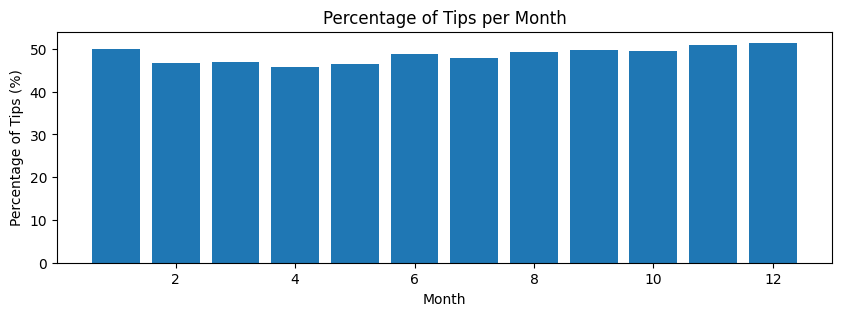

In [28]:
# Add weekday name
orders_and_tips['month'] = orders_and_tips['order_date'].dt.month

# Effekt des Monats
tip_by_testfeature = orders_and_tips[["month", "tip"]].groupby("month").mean() * 100
plt.figure(figsize=(10,3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel("Month")
plt.ylabel("Percentage of Tips (%)")
plt.title("Percentage of Tips per Month")
plt.show()

In [29]:
orders_and_tips = orders_and_tips.sort_values(["user_id", "order_date"])

# Anzahl vorheriger Tips
orders_and_tips['tip'] = orders_and_tips['tip'].astype(bool) 
orders_and_tips["total_previous_tips"] = orders_and_tips.groupby("user_id")["tip"].cumsum() - orders_and_tips["tip"] # Tip abziehen, da cumsum kumulative Summe inklusiver aktueller Zeile ist, aber diese Information in Zelle nicht vorliegt (Zeitreihe)

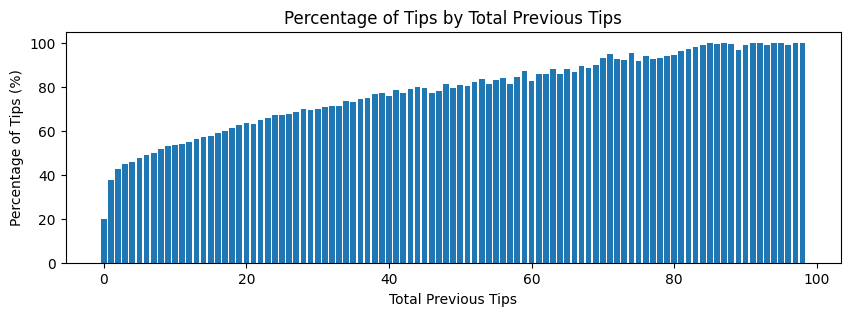

In [30]:
# Effekt des Monats
tip_by_testfeature = orders_and_tips[["total_previous_tips", "tip"]].groupby("total_previous_tips").mean() * 100
plt.figure(figsize=(10,3))
plt.bar(tip_by_testfeature.index, tip_by_testfeature["tip"])
plt.xlabel("Total Previous Tips")
plt.ylabel("Percentage of Tips (%)")
plt.title("Percentage of Tips by Total Previous Tips")
plt.show()

-> Effekt besteht für Total Previous Tips 

In [31]:
print(orders_and_tips.columns)

Index(['order_id', 'user_id', 'order_date', 'weekday', 'hour', 'week-start',
       'is_weekend', 'nr_previous_orders', 'days_since_last_order',
       'month-period', 'Unnamed: 0', 'tip', 'month', 'total_previous_tips'],
      dtype='object')


In [56]:
# Noch Previous und Pre-Previous Tips übernommen (erhalten dadurch halt wieder NaN-Werte)
orders_and_tips = orders_and_tips.sort_values(['user_id', 'order_date'])

orders_and_tips['previous_tip'] = orders_and_tips.groupby("user_id")['tip'].shift(1)
orders_and_tips['pre_previous_tip'] = orders_and_tips.groupby("user_id")['tip'].shift(2)

### Weiteres Vorgehen

Was fehlt noch für erste Abgabe:
- Wahrscheinlichkeitsvorhersage statt Klassifizierung für Tip (mit Log-Loss zur Bewertung)
- Decision Tree Vorhersage auf aktuelle Datenstruktur und aktuelle Aufteilung in Trainings- & Testdatensatz anwenden

To Dos danach: 
- Weitere Modellklassen testen (z.B. Decision Tree mit ID.3 oder C.4, KNN, Log. Regr., Neural Network?)
- Dokumentation (Variablen, Ergebnisse)
<br> <br>
***

In [57]:
print(orders_and_tips.columns)

Index(['order_id', 'user_id', 'order_date', 'weekday', 'hour', 'week-start',
       'is_weekend', 'nr_previous_orders', 'days_since_last_order',
       'month-period', 'Unnamed: 0', 'tip', 'month', 'total_previous_tips',
       'previous_tip', 'pre_previous_tip', 'tip_rate_hour_cum'],
      dtype='object')


In [46]:
orders_and_tips.head(10)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,month,total_previous_tips,previous_tip,pre_previous_tip
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True,3,0,NaN,NaN
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False,4,1,True,NaN
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False,4,1,False,True
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False,5,1,False,False
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True,6,1,False,False
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start,5.0,True,6,2,True,False
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle,6.0,False,6,3,True,True
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End,7.0,False,6,3,False,True
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End,8.0,False,6,3,False,False
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle,9.0,False,7,3,False,False


# Hinzufügen kumulative Tipp-Rate pro Stunde

In [52]:
# Sortiere nach Zeit, falls noch nicht geschehen
orders_and_tips = orders_and_tips.sort_values("order_date")

# Berechne kumulative Tipp-Rate je Stunde (ohne Leakage)
orders_and_tips['tip_rate_hour_cum'] = (
    orders_and_tips
    .groupby('hour')['tip']
    .transform(lambda x: x.shift().expanding().mean())
)

# Optional: Ersetze NaNs durch globalen Tipp-Mittelwert
global_tip_mean = orders_and_tips['tip'].mean()
orders_and_tips['tip_rate_hour_cum'] = orders_and_tips['tip_rate_hour_cum'].fillna(global_tip_mean)

In [87]:
orders_and_tips.head(10)

,order_id,user_id,order_date,weekday,hour,week-start,is_weekend,nr_previous_orders,days_since_last_order,month-period,Unnamed: 0,tip,month,total_previous_tips,previous_tip,pre_previous_tip,tip_rate_hour_cum
0,1374495,3,2024-03-31 14:05:18,Sunday,14,2024-03-25,1,0,0,End,0.0,True,3,0,NaN,NaN,0.426689
1,444309,3,2024-04-09 19:45:51,Tuesday,19,2024-04-08,0,1,9,Start,1.0,False,4,1,True,NaN,0.557482
2,3002854,3,2024-04-30 16:25:20,Tuesday,16,2024-04-29,0,2,20,End,2.0,False,4,1,False,True,0.428476
3,2037211,3,2024-05-20 18:31:28,Monday,18,2024-05-20,0,3,20,Middle,3.0,False,5,1,False,False,0.420425
4,2710558,3,2024-06-01 17:52:27,Saturday,17,2024-05-27,1,4,11,Start,4.0,True,6,1,False,False,0.423567
5,1972919,3,2024-06-08 16:55:12,Saturday,16,2024-06-03,1,5,6,Start,5.0,True,6,2,True,False,0.432478
6,1839752,3,2024-06-15 15:04:06,Saturday,15,2024-06-10,1,6,6,Middle,6.0,False,6,3,True,True,0.436020
7,3225766,3,2024-06-22 17:49:38,Saturday,17,2024-06-17,1,7,7,End,7.0,False,6,3,False,True,0.427655
8,3160850,3,2024-06-29 16:49:34,Saturday,16,2024-06-24,1,8,6,End,8.0,False,6,3,False,False,0.433984
9,676467,3,2024-07-16 16:27:44,Tuesday,16,2024-07-15,0,9,16,Middle,9.0,False,7,3,False,False,0.436043


# Check Korrelationsmatrix auf aktuellen Datenset

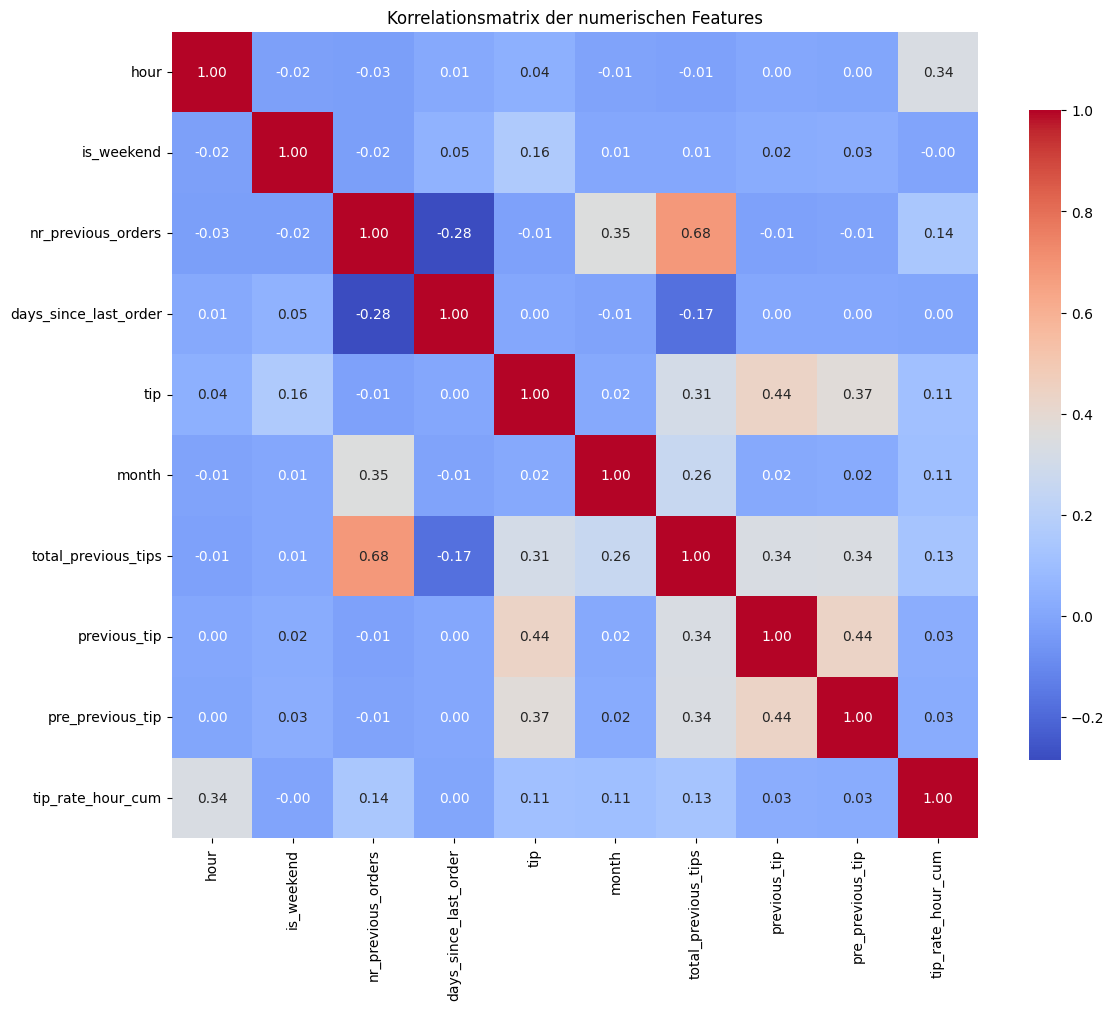

In [58]:
# Entferne unwichtige Spalten:
columns_to_drop = [col for col in ['Unnamed: 0', 'user_id', 'order_id', 'order_date'] if col in orders_and_tips.columns]
df_corr = orders_and_tips.drop(columns=columns_to_drop)

# Entferne NaN-Zeilen für die relevanten Spalten
df_corr = df_corr.dropna(subset=['tip', 'previous_tip', 'pre_previous_tip'])

# Konvertiere boolean Spalten zu int
for col in ['tip', 'previous_tip', 'pre_previous_tip']:
    df_corr[col] = df_corr[col].astype(int)

# Jetzt: Nur numerische Spalten auswählen
numeric_df = df_corr.select_dtypes(include=['number'])

# Korrelationsmatrix berechnen
corr_matrix = numeric_df.corr()

# Visualisierung
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Korrelationsmatrix der numerischen Features")
plt.tight_layout()
plt.show()

relevante Fatures (positive):

- previous_tip (0.44)
- pre_previous_tip (0.37)
- tip_rate_hour_cum (0.11)
- total_previous_tips (0.31)
- is_weekend (0.16)
- hour (0.04)
- month (0.02)

-> wir droppen nr_previous_orders und days_since_last_order für das Training

# Main Task A: Train Classification Model (Random Forest)

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# 1. Spalten droppen, die wir nicht als Features verwenden wollen
features_to_drop = ['nr_previous_orders', 'days_since_last_order', 'weekday', "week-start", "month-period"]

data = orders_and_tips.drop(columns=features_to_drop)

# 2. Letzte Bestellung pro Nutzer als Testset extrahieren
last_order_idx = data.groupby("user_id")["order_date"].idxmax()
test_set = data.loc[last_order_idx]

# 3. Trainingsdaten: alle Bestellungen außer die letzte pro Nutzer
train_set = data.drop(index=last_order_idx)

# 4. Sortieren nach Nutzer & Bestelldatum (optional, für Reproduzierbarkeit)
train_set = train_set.sort_values(by=["user_id", "order_date"])
test_set = test_set.sort_values(by=["user_id", "order_date"])

# 5. Features und Target definieren
columns_to_remove = ['user_id', 'order_id', 'order_date', 'tip']

X_train = train_set.drop(columns=columns_to_remove)
y_train = train_set['tip']

X_test = test_set.drop(columns=columns_to_remove)
y_test = test_set['tip']

# 6. NaN-Werte entfernen (sicherheitshalber, falls noch vorhanden)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [81]:
# 7. Check X-Trainset

X_train.head(10)

,hour,is_weekend,Unnamed: 0,month,total_previous_tips,previous_tip,pre_previous_tip,tip_rate_hour_cum
2,16,0,2.0,4,1,False,True,0.428476
3,18,0,3.0,5,1,False,False,0.420425
4,17,1,4.0,6,1,False,False,0.423567
5,16,1,5.0,6,2,True,False,0.432478
6,15,1,6.0,6,3,True,True,0.436020
7,17,1,7.0,6,3,False,True,0.427655
8,16,1,8.0,6,3,False,False,0.433984
9,16,0,9.0,7,3,False,False,0.436043
10,18,1,10.0,7,3,False,False,0.426196
15,18,0,15.0,4,0,False,False,0.414775


In [82]:
# 7. Check X-Testset

X_test.head(10)

,hour,is_weekend,Unnamed: 0,month,total_previous_tips,previous_tip,pre_previous_tip,tip_rate_hour_cum
11,15,1,11.0,8,3,False,False,0.441578
16,18,1,16.0,5,0,False,False,0.418446
20,18,0,20.0,2,2,True,True,0.411306
33,13,0,33.0,6,11,True,True,0.435721
56,10,1,56.0,10,5,True,False,0.468272
63,12,0,63.0,3,4,True,True,0.414115
73,16,0,73.0,5,1,True,False,0.430277
155,13,1,155.0,3,8,True,False,0.456094
174,11,0,174.0,8,3,False,False,0.450493
195,17,1,194.0,7,0,False,False,0.429399


In [83]:
# 8. Check y-Trainset

y_train.head(10)

2     False
3     False
4      True
5      True
6     False
7     False
8     False
9     False
10    False
15    False
Name: tip, dtype: bool

In [84]:
# 8. Check y-Testset

y_test.head(10)

11      True
16     False
20      True
33      True
56     False
63      True
73      True
155    False
174    False
195    False
Name: tip, dtype: bool

In [86]:
# 7. Random Forest Modell trainieren

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,           # Tiefe begrenzen auf 4
    min_samples_split=10,  # Mind. Proben für Split
    min_samples_leaf=5,    # Mind. Proben pro Blatt
    max_features='log2',   # Anzahl der Features pro Split = log2(Anzahl aller Features)
    random_state=42
)

clf.fit(X_train, y_train)

# 8. Modell auswerten
print(f"Train Accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("\nClassification Report:")
print(classification_report(y_test, clf.predict(X_test)))

Train Accuracy: 0.735
Test Accuracy: 0.750

Confusion Matrix:
[[27589  6631]
 [ 8865 18947]]

Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.81      0.78     34220
        True       0.74      0.68      0.71     27812

    accuracy                           0.75     62032
   macro avg       0.75      0.74      0.75     62032
weighted avg       0.75      0.75      0.75     62032



Auswertung:

- Von den tatsächlich „False“ wurden ca. 81% richtig erkannt (Recall False = 27589 / 34220).

- Von den tatsächlich „True“ wurden ca. 68% richtig erkannt (Recall True = 18947 / 27812).

Das heißt:

- False-Positives (fälschlich als True erkannt): 6631

- False-Negatives (fälschlich als False erkannt): 8865

# Main Task B: Wahrscheinlichkeitsvorhersage statt Klassifizierung für Tip (mit Log-Loss zur Bewertung)

In [100]:
from sklearn.metrics import log_loss, confusion_matrix, classification_report

# Wahrscheinlichkeiten vorhersagen
y_proba = clf.predict_proba(X_test)[:, 1]

# Log-Loss ausgeben
loss = log_loss(y_test, y_proba)
print(f"Log-Loss: {loss:.4f}")

# Wahrscheinlichkeiten für Klasse "True" (angenommen, Label = 1)
probs = clf.predict_proba(X_test)[:, 1]

# Wahre Labels
y_true = y_test.values

# Individuellen Log-Loss pro Beispiel berechnen
individual_log_loss = -(y_true * np.log(probs) + (1 - y_true) * np.log(1 - probs))

# Ausgabe der ersten 10 Beispiele mit: Index, Wahre Klasse, Vorhergesagte Wahrscheinlichkeit, Log-Loss
print("Index\tTrue Label\tW'keit\t        Log-Loss")
for i in range(10):
      print(f"{i}\t{y_true[i]}\t\t{probs[i]:.4f}\t\t{individual_log_loss[i]:.4f}")

Log-Loss: 0.5191
Index	True Label	W'keit	        Log-Loss
0	True		0.3527		1.0421
1	False		0.1794		0.1977
2	True		0.6920		0.3682
3	True		0.6925		0.3674
4	False		0.6070		0.9338
5	True		0.6921		0.3680
6	True		0.4564		0.7845
7	False		0.6115		0.9455
8	False		0.2348		0.2677
9	False		0.1469		0.1589


Interpretation:

- Log-Loss kann theoretisch von 0 (perfekt) bis unendlich gehen.

- Ein komplett zufälliges Modell, das immer 0.5 für beide Klassen vorhersagt, hat einen Log-Loss von etwa 0.693.

- 0.52 ist also deutlich besser als zufällig, aber nicht „sehr gut“

- Das Modell erreicht 75 % Accuracy — das bedeutet, dass 3 von 4 Fällen korrekt klassifiziert werden.

- Der Log-Loss von 0.52 zeigt, dass die Wahrscheinlichkeiten einiger Vorhersagen nicht sehr sicher sind oder teilweise falsch kalibriert (z.B. Wahrscheinlichkeiten nahe 0.5, obwohl die Klasse klar ist).

Es gibt also noch Verbesserungspotenzial bei der Konfidenz der Wahrscheinlichkeiten, auch wenn die Klasse oft richtig getroffen wird.